In [ ]:
# Introduction

Coronavirus disease (COVID-19) highlighted the need for fast, accessible, and low-cost
screening methods. Traditional testing approaches such as RT-PCR are accurate but
require laboratory infrastructure, trained personnel, and time, which limits their
availability in resource-constrained environments.

Recent studies have shown that cough sounds contain acoustic patterns that may differ
between COVID-19 positive and negative individuals. This project explores the use of
machine learning and deep learning techniques to automatically analyze cough audio
signals for COVID-19 detection.

In this assignment, the **CoughVID public dataset** is used, which contains cough audio
recordings along with metadata describing health status and recording quality. Audio
signals are preprocessed and converted into **Mel-spectrograms**, which capture
time–frequency characteristics of cough sounds.

A **Convolutional Neural Network (CNN)** model is trained to classify cough recordings
as COVID-19 positive or negative. Model performance is evaluated using accuracy,
confusion matrix, and prediction visualizations. The objective of this project is to
demonstrate how deep learning can be applied to biomedical audio data and assess its
potential as a preliminary screening tool.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

print("All libraries loaded successfully")


All libraries loaded successfully


In [4]:
DATASET_PATH = r"C:\Projects\Coughvid Dataset\public_dataset"
METADATA_PATH = os.path.join(DATASET_PATH, "metadata_compiled.csv")

print("Dataset path:", DATASET_PATH)
print("Metadata path:", METADATA_PATH)


Dataset path: C:\Projects\Coughvid Dataset\public_dataset
Metadata path: C:\Projects\Coughvid Dataset\public_dataset\metadata_compiled.csv


In [5]:
metadata = pd.read_csv(METADATA_PATH)

print("Total metadata rows:", len(metadata))
metadata[['uuid', 'status']].head()


Total metadata rows: 20072


,uuid,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,healthy
2,0012c608-33d0-4ef7-bde3-75a0b1a0024e,NaN
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,healthy
4,001c85a8-cc4d-4921-9297-848be52d4715,NaN


In [6]:
metadata = metadata[metadata['status'].isin(['healthy', 'COVID-19'])].copy()

metadata['label'] = metadata['status'].map({
    'healthy': 0,
    'COVID-19': 1
})

print("After filtering:", metadata['label'].value_counts())


After filtering: label
0    8562
1    1010
Name: count, dtype: int64


In [7]:
ogg_files = glob.glob(os.path.join(DATASET_PATH, "*.ogg"))

print("Total .ogg files found:", len(ogg_files))
print("Example file:", ogg_files[0])


Total .ogg files found: 859
Example file: C:\Projects\Coughvid Dataset\public_dataset\0080c4be-010c-4037-bba2-743437db3beb.ogg


In [8]:
audio_records = []

for path in ogg_files:
    uuid = os.path.basename(path).replace(".ogg", "")
    audio_records.append({
        "uuid": uuid,
        "audio_path": path
    })

ogg_df = pd.DataFrame(audio_records)

ogg_df.head()


,uuid,audio_path
0,0080c4be-010c-4037-bba2-743437db3beb,C:\Projects\Coughvid Dataset\public_dataset\00...
1,009e677f-e0ed-4765-9f9e-db3fff3921a3,C:\Projects\Coughvid Dataset\public_dataset\00...
2,009e762a-b4f7-41a6-a419-b4ca51be88ec,C:\Projects\Coughvid Dataset\public_dataset\00...
3,00a0156b-7179-4773-8a2c-4bb919e076bd,C:\Projects\Coughvid Dataset\public_dataset\00...
4,0288d081-951c-45f1-9fa6-9ce81a222716,C:\Projects\Coughvid Dataset\public_dataset\02...


In [9]:
metadata = pd.merge(
    metadata,
    ogg_df,
    on="uuid",
    how="inner"
)

print("Rows after merge:", len(metadata))
metadata[['uuid', 'audio_path']].head()


Rows after merge: 374


,uuid,audio_path
0,009e762a-b4f7-41a6-a419-b4ca51be88ec,C:\Projects\Coughvid Dataset\public_dataset\00...
1,00a0156b-7179-4773-8a2c-4bb919e076bd,C:\Projects\Coughvid Dataset\public_dataset\00...
2,02def005-fb2b-46aa-97ce-66262fb6f93d,C:\Projects\Coughvid Dataset\public_dataset\02...
3,0381caa3-fe32-4b67-9870-e254c9518e44,C:\Projects\Coughvid Dataset\public_dataset\03...
4,038593b5-6baa-4b8f-84fa-96ddda9736b0,C:\Projects\Coughvid Dataset\public_dataset\03...


Sample rate: 22050
Audio length: 220794


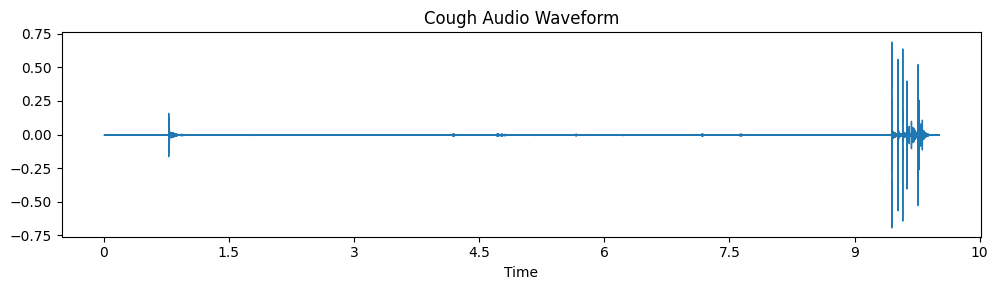

In [10]:
sample_path = metadata.iloc[0]['audio_path']

y, sr = librosa.load(sample_path, sr=22050)

print("Sample rate:", sr)
print("Audio length:", len(y))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Cough Audio Waveform")
plt.tight_layout()
plt.show()


Mel shape: (128, 432)


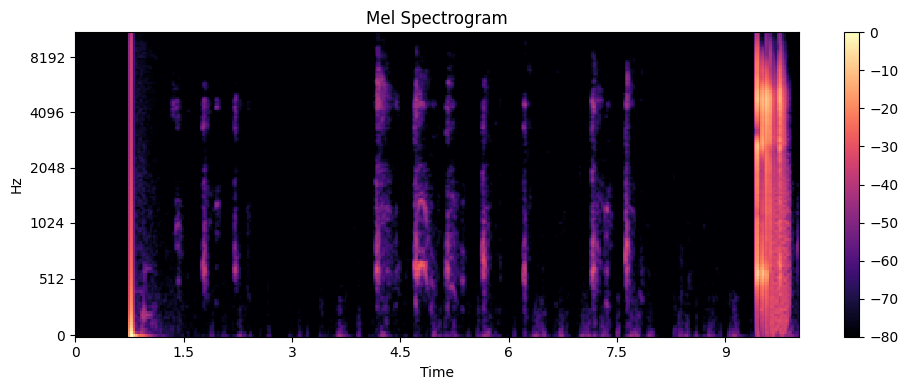

In [11]:
mel = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_mels=128,
    fmax=8000
)

mel_db = librosa.power_to_db(mel, ref=np.max)

print("Mel shape:", mel_db.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel_db,
    sr=sr,
    x_axis="time",
    y_axis="mel",
    cmap="magma"
)
plt.colorbar()
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()


In [12]:
def extract_mel(path, max_len=400):
    y, sr = librosa.load(path, sr=22050)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=128, fmax=8000
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)))
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db


In [13]:
X = []
y = []

for _, row in metadata.iterrows():
    try:
        mel = extract_mel(row['audio_path'])
        X.append(mel)
        y.append(row['label'])
    except:
        continue

X = np.array(X)
y = np.array(y)

print("Feature tensor shape:", X.shape)
print("Labels shape:", y.shape)


Feature tensor shape: (374, 128, 400)
Labels shape: (374,)


In [14]:
X = X[..., np.newaxis]  # add channel dim
y = to_categorical(y, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (299, 128, 400, 1)
Test: (75, 128, 400, 1)


In [27]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 398, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 199, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 63, 199, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 197, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86016)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,010,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,103,106 (42.35 MB)

 Trainable params: 11,103,106 (42.35 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8052 - loss: 42.9416 - val_accuracy: 0.9333 - val_loss: 0.6450
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9468 - loss: 0.2496 - val_accuracy: 0.9333 - val_loss: 0.6353
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 863ms/step - accuracy: 0.9358 - loss: 0.3322 - val_accuracy: 0.9333 - val_loss: 0.5124
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.9265 - loss: 0.3479 - val_accuracy: 0.9333 - val_loss: 0.4969
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.9478 - loss: 0.1984 - val_accuracy: 0.9333 - val_loss: 0.5207
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 595ms/step - accuracy: 0.9191 - loss: 0.2749 - val_accuracy: 0.9333 - val_loss: 0.5036
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 786ms/step - accuracy: 0.9269 - loss: 0.2447 - val_accuracy: 0.9333 - val_loss: 0.4808
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 700ms/step - accuracy: 0.9067 - loss: 0.4212 - val_accuracy:

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9315 - loss: 0.4279
Test accuracy: 0.9333333373069763


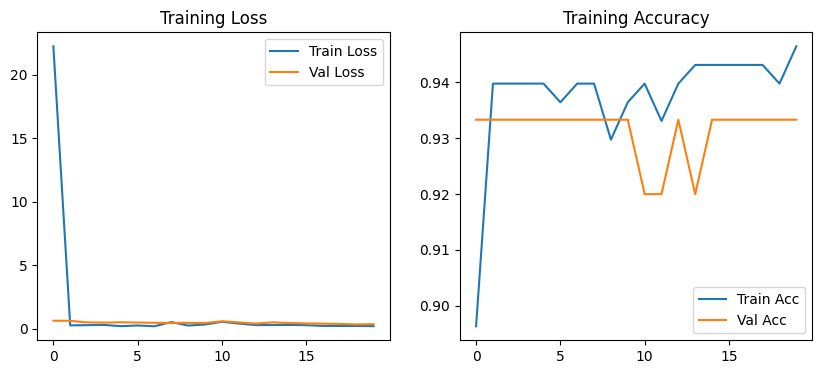

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training Accuracy")
plt.legend()

plt.show()



3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
y_test shape: (75,)
y_pred shape: (75,)


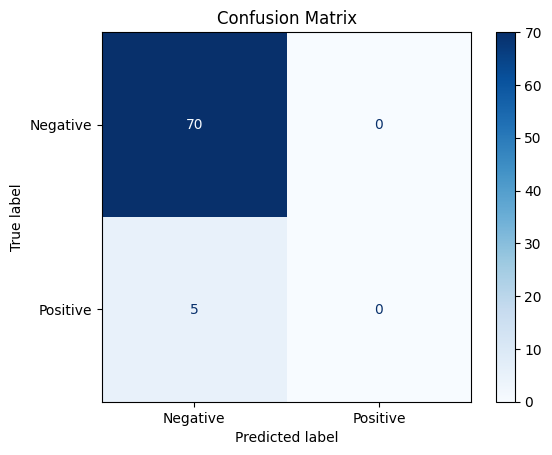

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot y_test → class labels
if len(y_test.shape) == 2:
    y_test_1d = np.argmax(y_test, axis=1)
else:
    y_test_1d = y_test

# Model predictions
y_pred_prob = model.predict(X_test)

# Convert predictions → class labels
if y_pred_prob.shape[1] == 2:
    y_pred_1d = np.argmax(y_pred_prob, axis=1)
else:
    y_pred_1d = (y_pred_prob > 0.5).astype(int).ravel()

print("y_test shape:", y_test_1d.shape)
print("y_pred shape:", y_pred_1d.shape)

# Confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [30]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import ipywidgets as widgets
import torch
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



# Automatically select GPU if available, else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


# Assuming 'metadata', 'model', 'DEVICE', and 'idx2label' are already defined

def audio_dashboard(index):
    row = metadata.iloc[index]
    path = row.audio_path
    true_label = row.status

    display(Audio(path))

    # Extract Mel-spectrogram
    y, sr = librosa.load(path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Prepare input for model
    x = torch.tensor(mel_db).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
    pred_label = idx2label[torch.argmax(model(x)).item()]

    print(f"True Label: {true_label} | Predicted Label: {pred_label}")

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram with Model Prediction")
    plt.tight_layout()
    plt.show()

# Create interactive dropdown
dropdown = widgets.Dropdown(
    options=[(f"{i} - {metadata.iloc[i].status}", i) for i in range(len(metadata))],
    description="Sample Index:"
)

widgets.interact(audio_dashboard, index=dropdown)


Using device: cpu


interactive(children=(Dropdown(description='Sample Index:', options=(('0 - healthy', 0), ('1 - healthy', 1), (…

<function __main__.audio_dashboard(index)>

In [ ]:
# Conclusion

This project demonstrated the feasibility of using deep learning techniques to classify
COVID-19 status from cough audio recordings. By preprocessing cough sounds into
Mel-spectrogram representations and training a Convolutional Neural Network, the model
was able to learn discriminative acoustic patterns associated with different health
conditions.

The trained model was evaluated using test data, confusion matrix, and single-sample
prediction visualizations. These results show that audio-based screening can provide
meaningful insights, although it should be considered as a **supportive screening tool**
rather than a definitive diagnostic method.

Several challenges were observed, including data imbalance, variability in recording
quality, and limited availability of labeled positive samples. Future improvements
could include larger datasets, advanced architectures, data augmentation techniques,
and multimodal learning that combines audio with clinical metadata.

Overall, this assignment successfully applied machine learning concepts to a real-world
healthcare problem, fulfilling the project objectives and demonstrating the practical
application of CNNs in audio signal analysis.
